# Install 

## Redis graph package

In [1]:
!pip install git+https://github.com/RedisGraph/redisgraph-py.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/RedisGraph/redisgraph-py.git to /tmp/pip-req-build-y1z31_41
  Running command git clone -q https://github.com/RedisGraph/redisgraph-py.git /tmp/pip-req-build-y1z31_41
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 85 kB 2.7 MB/s 
     |████████████████████████████████| 72 kB 304 kB/s 
  Created wheel for redisgraph: filename=redisgraph-2.4.4-py3-none-any.whl size=14410 sha256=69f102855380840894277d8c205ddaf5e2139dad93ed13d776af2f2435f20910
  Stored in directory: /tmp/pip-ephem-wheel-cache-oxnfdo2z/wheels/d3/53/30/fe227062a4bdd07bc4d6a356e1a2c0f7e4e93ba631da3104d2
Successfully built redisgraph
  Attempting uninstall: prettytable
    Found existing installation: prettytable 3.3.0
    Uninstalling prettytable-3.3.0:
      Successfully uninstalled

## Redis local server 

### Server 本體

In [ ]:
# !pip install redis-server redis
# 似乎不吃 redisgraph
# 移到下面與 module 一起裝

### install module: redisgraph.so (local 端）

I can't follow the installation steps on the official website.

So I found this issue and follow it.

https://github.com/RedisGraph/RedisGraph/issues/2352

It will take a long time to install, about 25 minutes.

In [ ]:
'''花很久時間'''
!apt-get install build-essential cmake m4 automake peg libtool autoconf
!git clone --recurse-submodules -j8 https://github.com/RedisGraph/RedisGraph.git
%cd RedisGraph/
!git submodule update --init --recursive
!make

In [ ]:
!git clone https://github.com/redis/redis.git
%cd redis
!make

### Active local server

Shutdown: 

```
/content/RedisGraph/redis/src/redis-cli shutdown
```

註：& 表 在背景執行


In [ ]:
!nohup /content/RedisGraph/redis/src/redis-server --loadmodule /content/RedisGraph/src/redisgraph.so &

nohup: appending output to 'nohup.out'


In [ ]:
!/content/redis/src/redis-server --version

Redis server v=255.255.255 sha=a4754e22:0 malloc=jemalloc-5.2.1 bits=64 build=fac6238e98098346


In [ ]:
!cat nohup.out

# Connect to server


In [2]:
import redis
from redisgraph import Node, Edge, Graph, Path
import networkx as nx

## local server

In [ ]:

r = redis.Redis(
    host='localhost', port=6379)
r.ping()

## redis cloud



In [3]:
r = redis.Redis(
	host='redis-14866.c81.us-east-1-2.ec2.cloud.redislabs.com',
	port=14866,
	password="vdEV0tCPjVNqqTvzILQHhdSwPvTaPzmo")
r.ping()

True

# Construct graph

## Redis package construct


```
social_graph = Graph('SocialMedia', r)
# 連接（不存在則建立） 在 DB 中名為 SocialMedia 的 graph
```

In [ ]:

# Define a graph called SocialMedia
social_graph = Graph('SocialMedia', r)


# Create nodes that represent users
users = {
    "Alex": Node(label="Person", properties={"name": "Alex", "age": 35}),
    "Jun": Node(label="Person", properties={"name": "Jun", "age": 33}),
    "Taylor": Node(label="Person", properties={"name": "Taylor", "age": 28}),
    "Noor": Node(label="Person", properties={"name": "Noor", "age": 41}),
    "Wei": Node(label="Person", properties={"name": "Wei", "age": 22}) }

# Add users to the graph as nodes
for key in users.keys():
    social_graph.add_node(users[key])

# Add relationships between user nodes
social_graph.add_edge( Edge(users["Alex"], "friends", users["Jun"]) )
# Make the relationship bidirectional
social_graph.add_edge( Edge(users["Jun"], "friends", users["Alex"]) )

social_graph.add_edge( Edge(users["Jun"], "friends", users["Taylor"]) )
social_graph.add_edge( Edge(users["Taylor"], "friends", users["Jun"]) )

social_graph.add_edge( Edge(users["Jun"], "friends", users["Noor"]) )
social_graph.add_edge( Edge(users["Noor"], "friends", users["Jun"]) )

# Create the graph in the database
social_graph.commit()

# Query the graph to find out how many friends Alex has
result1 = social_graph.query("MATCH (p1:Person {name: 'Alex'})-[:friends]->(p2:Person) RETURN count(p2)")
print("Alex's original friend count:", result1.result_set)

# Delete a relationship without deleting any user nodes
social_graph.query("MATCH (:Person {name: 'Alex'})<-[f:friends]->(:Person {name: 'Jun'}) DELETE f")

# Query the graph again to see Alex's updated friend count
result2 = social_graph.query("MATCH (p1:Person {name: 'Alex'})-[:friends]->(p2:Person) RETURN count(p2)")
print("Alex's updated friend count:", result2.result_set)

# Query all points and relation
result3 = social_graph.query("MATCH (n) -[r]-> (m) RETURN *")

# Delete the entire graph
# social_graph.delete()
# social_graph.query("MATCH (n) DETACH DELETE n")

Alex's original friend count: [[1]]
Alex's updated friend count: [[0]]


## cypher command

### hide query string
這個就是 neo4j 的 movie demo

In [ ]:
query_string = '''
CREATE (TheMatrix:Movie {title:'The Matrix', released:1999, tagline:'Welcome to the Real World'})
CREATE (Keanu:Person {name:'Keanu Reeves', born:1964})
CREATE (Carrie:Person {name:'Carrie-Anne Moss', born:1967})
CREATE (Laurence:Person {name:'Laurence Fishburne', born:1961})
CREATE (Hugo:Person {name:'Hugo Weaving', born:1960})
CREATE (LillyW:Person {name:'Lilly Wachowski', born:1967})
CREATE (LanaW:Person {name:'Lana Wachowski', born:1965})
CREATE (JoelS:Person {name:'Joel Silver', born:1952})
CREATE
(Keanu)-[:ACTED_IN {roles:['Neo']}]->(TheMatrix),
(Carrie)-[:ACTED_IN {roles:['Trinity']}]->(TheMatrix),
(Laurence)-[:ACTED_IN {roles:['Morpheus']}]->(TheMatrix),
(Hugo)-[:ACTED_IN {roles:['Agent Smith']}]->(TheMatrix),
(LillyW)-[:DIRECTED]->(TheMatrix),
(LanaW)-[:DIRECTED]->(TheMatrix),
(JoelS)-[:PRODUCED]->(TheMatrix)

CREATE (Emil:Person {name:"Emil Eifrem", born:1978})
CREATE (Emil)-[:ACTED_IN {roles:["Emil"]}]->(TheMatrix)

CREATE (TheMatrixReloaded:Movie {title:'The Matrix Reloaded', released:2003, tagline:'Free your mind'})
CREATE
(Keanu)-[:ACTED_IN {roles:['Neo']}]->(TheMatrixReloaded),
(Carrie)-[:ACTED_IN {roles:['Trinity']}]->(TheMatrixReloaded),
(Laurence)-[:ACTED_IN {roles:['Morpheus']}]->(TheMatrixReloaded),
(Hugo)-[:ACTED_IN {roles:['Agent Smith']}]->(TheMatrixReloaded),
(LillyW)-[:DIRECTED]->(TheMatrixReloaded),
(LanaW)-[:DIRECTED]->(TheMatrixReloaded),
(JoelS)-[:PRODUCED]->(TheMatrixReloaded)

CREATE (TheMatrixRevolutions:Movie {title:'The Matrix Revolutions', released:2003, tagline:'Everything that has a beginning has an end'})
CREATE
(Keanu)-[:ACTED_IN {roles:['Neo']}]->(TheMatrixRevolutions),
(Carrie)-[:ACTED_IN {roles:['Trinity']}]->(TheMatrixRevolutions),
(Laurence)-[:ACTED_IN {roles:['Morpheus']}]->(TheMatrixRevolutions),
(Hugo)-[:ACTED_IN {roles:['Agent Smith']}]->(TheMatrixRevolutions),
(LillyW)-[:DIRECTED]->(TheMatrixRevolutions),
(LanaW)-[:DIRECTED]->(TheMatrixRevolutions),
(JoelS)-[:PRODUCED]->(TheMatrixRevolutions)

CREATE (TheDevilsAdvocate:Movie {title:"The Devil's Advocate", released:1997, tagline:'Evil has its winning ways'})
CREATE (Charlize:Person {name:'Charlize Theron', born:1975})
CREATE (Al:Person {name:'Al Pacino', born:1940})
CREATE (Taylor:Person {name:'Taylor Hackford', born:1944})
CREATE
(Keanu)-[:ACTED_IN {roles:['Kevin Lomax']}]->(TheDevilsAdvocate),
(Charlize)-[:ACTED_IN {roles:['Mary Ann Lomax']}]->(TheDevilsAdvocate),
(Al)-[:ACTED_IN {roles:['John Milton']}]->(TheDevilsAdvocate),
(Taylor)-[:DIRECTED]->(TheDevilsAdvocate)

CREATE (AFewGoodMen:Movie {title:"A Few Good Men", released:1992, tagline:"In the heart of the nation's capital, in a courthouse of the U.S. government, one man will stop at nothing to keep his honor, and one will stop at nothing to find the truth."})
CREATE (TomC:Person {name:'Tom Cruise', born:1962})
CREATE (JackN:Person {name:'Jack Nicholson', born:1937})
CREATE (DemiM:Person {name:'Demi Moore', born:1962})
CREATE (KevinB:Person {name:'Kevin Bacon', born:1958})
CREATE (KieferS:Person {name:'Kiefer Sutherland', born:1966})
CREATE (NoahW:Person {name:'Noah Wyle', born:1971})
CREATE (CubaG:Person {name:'Cuba Gooding Jr.', born:1968})
CREATE (KevinP:Person {name:'Kevin Pollak', born:1957})
CREATE (JTW:Person {name:'J.T. Walsh', born:1943})
CREATE (JamesM:Person {name:'James Marshall', born:1967})
CREATE (ChristopherG:Person {name:'Christopher Guest', born:1948})
CREATE (RobR:Person {name:'Rob Reiner', born:1947})
CREATE (AaronS:Person {name:'Aaron Sorkin', born:1961})
CREATE
(TomC)-[:ACTED_IN {roles:['Lt. Daniel Kaffee']}]->(AFewGoodMen),
(JackN)-[:ACTED_IN {roles:['Col. Nathan R. Jessup']}]->(AFewGoodMen),
(DemiM)-[:ACTED_IN {roles:['Lt. Cdr. JoAnne Galloway']}]->(AFewGoodMen),
(KevinB)-[:ACTED_IN {roles:['Capt. Jack Ross']}]->(AFewGoodMen),
(KieferS)-[:ACTED_IN {roles:['Lt. Jonathan Kendrick']}]->(AFewGoodMen),
(NoahW)-[:ACTED_IN {roles:['Cpl. Jeffrey Barnes']}]->(AFewGoodMen),
(CubaG)-[:ACTED_IN {roles:['Cpl. Carl Hammaker']}]->(AFewGoodMen),
(KevinP)-[:ACTED_IN {roles:['Lt. Sam Weinberg']}]->(AFewGoodMen),
(JTW)-[:ACTED_IN {roles:['Lt. Col. Matthew Andrew Markinson']}]->(AFewGoodMen),
(JamesM)-[:ACTED_IN {roles:['Pfc. Louden Downey']}]->(AFewGoodMen),
(ChristopherG)-[:ACTED_IN {roles:['Dr. Stone']}]->(AFewGoodMen),
(AaronS)-[:ACTED_IN {roles:['Man in Bar']}]->(AFewGoodMen),
(RobR)-[:DIRECTED]->(AFewGoodMen),
(AaronS)-[:WROTE]->(AFewGoodMen)

CREATE (TopGun:Movie {title:"Top Gun", released:1986, tagline:'I feel the need, the need for speed.'})
CREATE (KellyM:Person {name:'Kelly McGillis', born:1957})
CREATE (ValK:Person {name:'Val Kilmer', born:1959})
CREATE (AnthonyE:Person {name:'Anthony Edwards', born:1962})
CREATE (TomS:Person {name:'Tom Skerritt', born:1933})
CREATE (MegR:Person {name:'Meg Ryan', born:1961})
CREATE (TonyS:Person {name:'Tony Scott', born:1944})
CREATE (JimC:Person {name:'Jim Cash', born:1941})
CREATE
(TomC)-[:ACTED_IN {roles:['Maverick']}]->(TopGun),
(KellyM)-[:ACTED_IN {roles:['Charlie']}]->(TopGun),
(ValK)-[:ACTED_IN {roles:['Iceman']}]->(TopGun),
(AnthonyE)-[:ACTED_IN {roles:['Goose']}]->(TopGun),
(TomS)-[:ACTED_IN {roles:['Viper']}]->(TopGun),
(MegR)-[:ACTED_IN {roles:['Carole']}]->(TopGun),
(TonyS)-[:DIRECTED]->(TopGun),
(JimC)-[:WROTE]->(TopGun)

CREATE (JerryMaguire:Movie {title:'Jerry Maguire', released:2000, tagline:'The rest of his life begins now.'})
CREATE (ReneeZ:Person {name:'Renee Zellweger', born:1969})
CREATE (KellyP:Person {name:'Kelly Preston', born:1962})
CREATE (JerryO:Person {name:"Jerry O'Connell", born:1974})
CREATE (JayM:Person {name:'Jay Mohr', born:1970})
CREATE (BonnieH:Person {name:'Bonnie Hunt', born:1961})
CREATE (ReginaK:Person {name:'Regina King', born:1971})
CREATE (JonathanL:Person {name:'Jonathan Lipnicki', born:1996})
CREATE (CameronC:Person {name:'Cameron Crowe', born:1957})
CREATE
(TomC)-[:ACTED_IN {roles:['Jerry Maguire']}]->(JerryMaguire),
(CubaG)-[:ACTED_IN {roles:['Rod Tidwell']}]->(JerryMaguire),
(ReneeZ)-[:ACTED_IN {roles:['Dorothy Boyd']}]->(JerryMaguire),
(KellyP)-[:ACTED_IN {roles:['Avery Bishop']}]->(JerryMaguire),
(JerryO)-[:ACTED_IN {roles:['Frank Cushman']}]->(JerryMaguire),
(JayM)-[:ACTED_IN {roles:['Bob Sugar']}]->(JerryMaguire),
(BonnieH)-[:ACTED_IN {roles:['Laurel Boyd']}]->(JerryMaguire),
(ReginaK)-[:ACTED_IN {roles:['Marcee Tidwell']}]->(JerryMaguire),
(JonathanL)-[:ACTED_IN {roles:['Ray Boyd']}]->(JerryMaguire),
(CameronC)-[:DIRECTED]->(JerryMaguire),
(CameronC)-[:PRODUCED]->(JerryMaguire),
(CameronC)-[:WROTE]->(JerryMaguire)

CREATE (StandByMe:Movie {title:"Stand By Me", released:1986, tagline:"For some, it's the last real taste of innocence, and the first real taste of life. But for everyone, it's the time that memories are made of."})
CREATE (RiverP:Person {name:'River Phoenix', born:1970})
CREATE (CoreyF:Person {name:'Corey Feldman', born:1971})
CREATE (WilW:Person {name:'Wil Wheaton', born:1972})
CREATE (JohnC:Person {name:'John Cusack', born:1966})
CREATE (MarshallB:Person {name:'Marshall Bell', born:1942})
CREATE
(WilW)-[:ACTED_IN {roles:['Gordie Lachance']}]->(StandByMe),
(RiverP)-[:ACTED_IN {roles:['Chris Chambers']}]->(StandByMe),
(JerryO)-[:ACTED_IN {roles:['Vern Tessio']}]->(StandByMe),
(CoreyF)-[:ACTED_IN {roles:['Teddy Duchamp']}]->(StandByMe),
(JohnC)-[:ACTED_IN {roles:['Denny Lachance']}]->(StandByMe),
(KieferS)-[:ACTED_IN {roles:['Ace Merrill']}]->(StandByMe),
(MarshallB)-[:ACTED_IN {roles:['Mr. Lachance']}]->(StandByMe),
(RobR)-[:DIRECTED]->(StandByMe)

CREATE (AsGoodAsItGets:Movie {title:'As Good as It Gets', released:1997, tagline:'A comedy from the heart that goes for the throat.'})
CREATE (HelenH:Person {name:'Helen Hunt', born:1963})
CREATE (GregK:Person {name:'Greg Kinnear', born:1963})
CREATE (JamesB:Person {name:'James L. Brooks', born:1940})
CREATE
(JackN)-[:ACTED_IN {roles:['Melvin Udall']}]->(AsGoodAsItGets),
(HelenH)-[:ACTED_IN {roles:['Carol Connelly']}]->(AsGoodAsItGets),
(GregK)-[:ACTED_IN {roles:['Simon Bishop']}]->(AsGoodAsItGets),
(CubaG)-[:ACTED_IN {roles:['Frank Sachs']}]->(AsGoodAsItGets),
(JamesB)-[:DIRECTED]->(AsGoodAsItGets)

CREATE (WhatDreamsMayCome:Movie {title:'What Dreams May Come', released:1998, tagline:'After life there is more. The end is just the beginning.'})
CREATE (AnnabellaS:Person {name:'Annabella Sciorra', born:1960})
CREATE (MaxS:Person {name:'Max von Sydow', born:1929})
CREATE (WernerH:Person {name:'Werner Herzog', born:1942})
CREATE (Robin:Person {name:'Robin Williams', born:1951})
CREATE (VincentW:Person {name:'Vincent Ward', born:1956})
CREATE
(Robin)-[:ACTED_IN {roles:['Chris Nielsen']}]->(WhatDreamsMayCome),
(CubaG)-[:ACTED_IN {roles:['Albert Lewis']}]->(WhatDreamsMayCome),
(AnnabellaS)-[:ACTED_IN {roles:['Annie Collins-Nielsen']}]->(WhatDreamsMayCome),
(MaxS)-[:ACTED_IN {roles:['The Tracker']}]->(WhatDreamsMayCome),
(WernerH)-[:ACTED_IN {roles:['The Face']}]->(WhatDreamsMayCome),
(VincentW)-[:DIRECTED]->(WhatDreamsMayCome)

CREATE (SnowFallingonCedars:Movie {title:'Snow Falling on Cedars', released:1999, tagline:'First loves last. Forever.'})
CREATE (EthanH:Person {name:'Ethan Hawke', born:1970})
CREATE (RickY:Person {name:'Rick Yune', born:1971})
CREATE (JamesC:Person {name:'James Cromwell', born:1940})
CREATE (ScottH:Person {name:'Scott Hicks', born:1953})
CREATE
(EthanH)-[:ACTED_IN {roles:['Ishmael Chambers']}]->(SnowFallingonCedars),
(RickY)-[:ACTED_IN {roles:['Kazuo Miyamoto']}]->(SnowFallingonCedars),
(MaxS)-[:ACTED_IN {roles:['Nels Gudmundsson']}]->(SnowFallingonCedars),
(JamesC)-[:ACTED_IN {roles:['Judge Fielding']}]->(SnowFallingonCedars),
(ScottH)-[:DIRECTED]->(SnowFallingonCedars)

CREATE (YouveGotMail:Movie {title:"You've Got Mail", released:1998, tagline:'At odds in life... in love on-line.'})
CREATE (ParkerP:Person {name:'Parker Posey', born:1968})
CREATE (DaveC:Person {name:'Dave Chappelle', born:1973})
CREATE (SteveZ:Person {name:'Steve Zahn', born:1967})
CREATE (TomH:Person {name:'Tom Hanks', born:1956})
CREATE (NoraE:Person {name:'Nora Ephron', born:1941})
CREATE
(TomH)-[:ACTED_IN {roles:['Joe Fox']}]->(YouveGotMail),
(MegR)-[:ACTED_IN {roles:['Kathleen Kelly']}]->(YouveGotMail),
(GregK)-[:ACTED_IN {roles:['Frank Navasky']}]->(YouveGotMail),
(ParkerP)-[:ACTED_IN {roles:['Patricia Eden']}]->(YouveGotMail),
(DaveC)-[:ACTED_IN {roles:['Kevin Jackson']}]->(YouveGotMail),
(SteveZ)-[:ACTED_IN {roles:['George Pappas']}]->(YouveGotMail),
(NoraE)-[:DIRECTED]->(YouveGotMail)

CREATE (SleeplessInSeattle:Movie {title:'Sleepless in Seattle', released:1993, tagline:'What if someone you never met, someone you never saw, someone you never knew was the only someone for you?'})
CREATE (RitaW:Person {name:'Rita Wilson', born:1956})
CREATE (BillPull:Person {name:'Bill Pullman', born:1953})
CREATE (VictorG:Person {name:'Victor Garber', born:1949})
CREATE (RosieO:Person {name:"Rosie O'Donnell", born:1962})
CREATE
(TomH)-[:ACTED_IN {roles:['Sam Baldwin']}]->(SleeplessInSeattle),
(MegR)-[:ACTED_IN {roles:['Annie Reed']}]->(SleeplessInSeattle),
(RitaW)-[:ACTED_IN {roles:['Suzy']}]->(SleeplessInSeattle),
(BillPull)-[:ACTED_IN {roles:['Walter']}]->(SleeplessInSeattle),
(VictorG)-[:ACTED_IN {roles:['Greg']}]->(SleeplessInSeattle),
(RosieO)-[:ACTED_IN {roles:['Becky']}]->(SleeplessInSeattle),
(NoraE)-[:DIRECTED]->(SleeplessInSeattle)

CREATE (JoeVersustheVolcano:Movie {title:'Joe Versus the Volcano', released:1990, tagline:'A story of love, lava and burning desire.'})
CREATE (JohnS:Person {name:'John Patrick Stanley', born:1950})
CREATE (Nathan:Person {name:'Nathan Lane', born:1956})
CREATE
(TomH)-[:ACTED_IN {roles:['Joe Banks']}]->(JoeVersustheVolcano),
(MegR)-[:ACTED_IN {roles:['DeDe', 'Angelica Graynamore', 'Patricia Graynamore']}]->(JoeVersustheVolcano),
(Nathan)-[:ACTED_IN {roles:['Baw']}]->(JoeVersustheVolcano),
(JohnS)-[:DIRECTED]->(JoeVersustheVolcano)

CREATE (WhenHarryMetSally:Movie {title:'When Harry Met Sally', released:1998, tagline:'Can two friends sleep together and still love each other in the morning?'})
CREATE (BillyC:Person {name:'Billy Crystal', born:1948})
CREATE (CarrieF:Person {name:'Carrie Fisher', born:1956})
CREATE (BrunoK:Person {name:'Bruno Kirby', born:1949})
CREATE
(BillyC)-[:ACTED_IN {roles:['Harry Burns']}]->(WhenHarryMetSally),
(MegR)-[:ACTED_IN {roles:['Sally Albright']}]->(WhenHarryMetSally),
(CarrieF)-[:ACTED_IN {roles:['Marie']}]->(WhenHarryMetSally),
(BrunoK)-[:ACTED_IN {roles:['Jess']}]->(WhenHarryMetSally),
(RobR)-[:DIRECTED]->(WhenHarryMetSally),
(RobR)-[:PRODUCED]->(WhenHarryMetSally),
(NoraE)-[:PRODUCED]->(WhenHarryMetSally),
(NoraE)-[:WROTE]->(WhenHarryMetSally)

CREATE (ThatThingYouDo:Movie {title:'That Thing You Do', released:1996, tagline:'In every life there comes a time when that thing you dream becomes that thing you do'})
CREATE (LivT:Person {name:'Liv Tyler', born:1977})
CREATE
(TomH)-[:ACTED_IN {roles:['Mr. White']}]->(ThatThingYouDo),
(LivT)-[:ACTED_IN {roles:['Faye Dolan']}]->(ThatThingYouDo),
(Charlize)-[:ACTED_IN {roles:['Tina']}]->(ThatThingYouDo),
(TomH)-[:DIRECTED]->(ThatThingYouDo)

CREATE (TheReplacements:Movie {title:'The Replacements', released:2000, tagline:'Pain heals, Chicks dig scars... Glory lasts forever'})
CREATE (Brooke:Person {name:'Brooke Langton', born:1970})
CREATE (Gene:Person {name:'Gene Hackman', born:1930})
CREATE (Orlando:Person {name:'Orlando Jones', born:1968})
CREATE (Howard:Person {name:'Howard Deutch', born:1950})
CREATE
(Keanu)-[:ACTED_IN {roles:['Shane Falco']}]->(TheReplacements),
(Brooke)-[:ACTED_IN {roles:['Annabelle Farrell']}]->(TheReplacements),
(Gene)-[:ACTED_IN {roles:['Jimmy McGinty']}]->(TheReplacements),
(Orlando)-[:ACTED_IN {roles:['Clifford Franklin']}]->(TheReplacements),
(Howard)-[:DIRECTED]->(TheReplacements)

CREATE (RescueDawn:Movie {title:'RescueDawn', released:2006, tagline:"Based on the extraordinary true story of one man's fight for freedom"})
CREATE (ChristianB:Person {name:'Christian Bale', born:1974})
CREATE (ZachG:Person {name:'Zach Grenier', born:1954})
CREATE
(MarshallB)-[:ACTED_IN {roles:['Admiral']}]->(RescueDawn),
(ChristianB)-[:ACTED_IN {roles:['Dieter Dengler']}]->(RescueDawn),
(ZachG)-[:ACTED_IN {roles:['Squad Leader']}]->(RescueDawn),
(SteveZ)-[:ACTED_IN {roles:['Duane']}]->(RescueDawn),
(WernerH)-[:DIRECTED]->(RescueDawn)

CREATE (TheBirdcage:Movie {title:'The Birdcage', released:1996, tagline:'Come as you are'})
CREATE (MikeN:Person {name:'Mike Nichols', born:1931})
CREATE
(Robin)-[:ACTED_IN {roles:['Armand Goldman']}]->(TheBirdcage),
(Nathan)-[:ACTED_IN {roles:['Albert Goldman']}]->(TheBirdcage),
(Gene)-[:ACTED_IN {roles:['Sen. Kevin Keeley']}]->(TheBirdcage),
(MikeN)-[:DIRECTED]->(TheBirdcage)

CREATE (Unforgiven:Movie {title:'Unforgiven', released:1992, tagline:"It's a hell of a thing, killing a man"})
CREATE (RichardH:Person {name:'Richard Harris', born:1930})
CREATE (ClintE:Person {name:'Clint Eastwood', born:1930})
CREATE
(RichardH)-[:ACTED_IN {roles:['English Bob']}]->(Unforgiven),
(ClintE)-[:ACTED_IN {roles:['Bill Munny']}]->(Unforgiven),
(Gene)-[:ACTED_IN {roles:['Little Bill Daggett']}]->(Unforgiven),
(ClintE)-[:DIRECTED]->(Unforgiven)

CREATE (JohnnyMnemonic:Movie {title:'Johnny Mnemonic', released:1995, tagline:'The hottest data on earth. In the coolest head in town'})
CREATE (Takeshi:Person {name:'Takeshi Kitano', born:1947})
CREATE (Dina:Person {name:'Dina Meyer', born:1968})
CREATE (IceT:Person {name:'Ice-T', born:1958})
CREATE (RobertL:Person {name:'Robert Longo', born:1953})
CREATE
(Keanu)-[:ACTED_IN {roles:['Johnny Mnemonic']}]->(JohnnyMnemonic),
(Takeshi)-[:ACTED_IN {roles:['Takahashi']}]->(JohnnyMnemonic),
(Dina)-[:ACTED_IN {roles:['Jane']}]->(JohnnyMnemonic),
(IceT)-[:ACTED_IN {roles:['J-Bone']}]->(JohnnyMnemonic),
(RobertL)-[:DIRECTED]->(JohnnyMnemonic)

CREATE (CloudAtlas:Movie {title:'Cloud Atlas', released:2012, tagline:'Everything is connected'})
CREATE (HalleB:Person {name:'Halle Berry', born:1966})
CREATE (JimB:Person {name:'Jim Broadbent', born:1949})
CREATE (TomT:Person {name:'Tom Tykwer', born:1965})
CREATE (DavidMitchell:Person {name:'David Mitchell', born:1969})
CREATE (StefanArndt:Person {name:'Stefan Arndt', born:1961})
CREATE
(TomH)-[:ACTED_IN {roles:['Zachry', 'Dr. Henry Goose', 'Isaac Sachs', 'Dermot Hoggins']}]->(CloudAtlas),
(Hugo)-[:ACTED_IN {roles:['Bill Smoke', 'Haskell Moore', 'Tadeusz Kesselring', 'Nurse Noakes', 'Boardman Mephi', 'Old Georgie']}]->(CloudAtlas),
(HalleB)-[:ACTED_IN {roles:['Luisa Rey', 'Jocasta Ayrs', 'Ovid', 'Meronym']}]->(CloudAtlas),
(JimB)-[:ACTED_IN {roles:['Vyvyan Ayrs', 'Captain Molyneux', 'Timothy Cavendish']}]->(CloudAtlas),
(TomT)-[:DIRECTED]->(CloudAtlas),
(LillyW)-[:DIRECTED]->(CloudAtlas),
(LanaW)-[:DIRECTED]->(CloudAtlas),
(DavidMitchell)-[:WROTE]->(CloudAtlas),
(StefanArndt)-[:PRODUCED]->(CloudAtlas)

CREATE (TheDaVinciCode:Movie {title:'The Da Vinci Code', released:2006, tagline:'Break The Codes'})
CREATE (IanM:Person {name:'Ian McKellen', born:1939})
CREATE (AudreyT:Person {name:'Audrey Tautou', born:1976})
CREATE (PaulB:Person {name:'Paul Bettany', born:1971})
CREATE (RonH:Person {name:'Ron Howard', born:1954})
CREATE
(TomH)-[:ACTED_IN {roles:['Dr. Robert Langdon']}]->(TheDaVinciCode),
(IanM)-[:ACTED_IN {roles:['Sir Leight Teabing']}]->(TheDaVinciCode),
(AudreyT)-[:ACTED_IN {roles:['Sophie Neveu']}]->(TheDaVinciCode),
(PaulB)-[:ACTED_IN {roles:['Silas']}]->(TheDaVinciCode),
(RonH)-[:DIRECTED]->(TheDaVinciCode)

CREATE (VforVendetta:Movie {title:'V for Vendetta', released:2006, tagline:'Freedom! Forever!'})
CREATE (NatalieP:Person {name:'Natalie Portman', born:1981})
CREATE (StephenR:Person {name:'Stephen Rea', born:1946})
CREATE (JohnH:Person {name:'John Hurt', born:1940})
CREATE (BenM:Person {name: 'Ben Miles', born:1967})
CREATE
(Hugo)-[:ACTED_IN {roles:['V']}]->(VforVendetta),
(NatalieP)-[:ACTED_IN {roles:['Evey Hammond']}]->(VforVendetta),
(StephenR)-[:ACTED_IN {roles:['Eric Finch']}]->(VforVendetta),
(JohnH)-[:ACTED_IN {roles:['High Chancellor Adam Sutler']}]->(VforVendetta),
(BenM)-[:ACTED_IN {roles:['Dascomb']}]->(VforVendetta),
(JamesM)-[:DIRECTED]->(VforVendetta),
(LillyW)-[:PRODUCED]->(VforVendetta),
(LanaW)-[:PRODUCED]->(VforVendetta),
(JoelS)-[:PRODUCED]->(VforVendetta),
(LillyW)-[:WROTE]->(VforVendetta),
(LanaW)-[:WROTE]->(VforVendetta)

CREATE (SpeedRacer:Movie {title:'Speed Racer', released:2008, tagline:'Speed has no limits'})
CREATE (EmileH:Person {name:'Emile Hirsch', born:1985})
CREATE (JohnG:Person {name:'John Goodman', born:1960})
CREATE (SusanS:Person {name:'Susan Sarandon', born:1946})
CREATE (MatthewF:Person {name:'Matthew Fox', born:1966})
CREATE (ChristinaR:Person {name:'Christina Ricci', born:1980})
CREATE (Rain:Person {name:'Rain', born:1982})
CREATE
(EmileH)-[:ACTED_IN {roles:['Speed Racer']}]->(SpeedRacer),
(JohnG)-[:ACTED_IN {roles:['Pops']}]->(SpeedRacer),
(SusanS)-[:ACTED_IN {roles:['Mom']}]->(SpeedRacer),
(MatthewF)-[:ACTED_IN {roles:['Racer X']}]->(SpeedRacer),
(ChristinaR)-[:ACTED_IN {roles:['Trixie']}]->(SpeedRacer),
(Rain)-[:ACTED_IN {roles:['Taejo Togokahn']}]->(SpeedRacer),
(BenM)-[:ACTED_IN {roles:['Cass Jones']}]->(SpeedRacer),
(LillyW)-[:DIRECTED]->(SpeedRacer),
(LanaW)-[:DIRECTED]->(SpeedRacer),
(LillyW)-[:WROTE]->(SpeedRacer),
(LanaW)-[:WROTE]->(SpeedRacer),
(JoelS)-[:PRODUCED]->(SpeedRacer)

CREATE (NinjaAssassin:Movie {title:'Ninja Assassin', released:2009, tagline:'Prepare to enter a secret world of assassins'})
CREATE (NaomieH:Person {name:'Naomie Harris'})
CREATE
(Rain)-[:ACTED_IN {roles:['Raizo']}]->(NinjaAssassin),
(NaomieH)-[:ACTED_IN {roles:['Mika Coretti']}]->(NinjaAssassin),
(RickY)-[:ACTED_IN {roles:['Takeshi']}]->(NinjaAssassin),
(BenM)-[:ACTED_IN {roles:['Ryan Maslow']}]->(NinjaAssassin),
(JamesM)-[:DIRECTED]->(NinjaAssassin),
(LillyW)-[:PRODUCED]->(NinjaAssassin),
(LanaW)-[:PRODUCED]->(NinjaAssassin),
(JoelS)-[:PRODUCED]->(NinjaAssassin)

CREATE (TheGreenMile:Movie {title:'The Green Mile', released:1999, tagline:"Walk a mile you'll never forget."})
CREATE (MichaelD:Person {name:'Michael Clarke Duncan', born:1957})
CREATE (DavidM:Person {name:'David Morse', born:1953})
CREATE (SamR:Person {name:'Sam Rockwell', born:1968})
CREATE (GaryS:Person {name:'Gary Sinise', born:1955})
CREATE (PatriciaC:Person {name:'Patricia Clarkson', born:1959})
CREATE (FrankD:Person {name:'Frank Darabont', born:1959})
CREATE
(TomH)-[:ACTED_IN {roles:['Paul Edgecomb']}]->(TheGreenMile),
(MichaelD)-[:ACTED_IN {roles:['John Coffey']}]->(TheGreenMile),
(DavidM)-[:ACTED_IN {roles:['Brutus "Brutal" Howell']}]->(TheGreenMile),
(BonnieH)-[:ACTED_IN {roles:['Jan Edgecomb']}]->(TheGreenMile),
(JamesC)-[:ACTED_IN {roles:['Warden Hal Moores']}]->(TheGreenMile),
(SamR)-[:ACTED_IN {roles:['"Wild Bill" Wharton']}]->(TheGreenMile),
(GaryS)-[:ACTED_IN {roles:['Burt Hammersmith']}]->(TheGreenMile),
(PatriciaC)-[:ACTED_IN {roles:['Melinda Moores']}]->(TheGreenMile),
(FrankD)-[:DIRECTED]->(TheGreenMile)

CREATE (FrostNixon:Movie {title:'Frost/Nixon', released:2008, tagline:'400 million people were waiting for the truth.'})
CREATE (FrankL:Person {name:'Frank Langella', born:1938})
CREATE (MichaelS:Person {name:'Michael Sheen', born:1969})
CREATE (OliverP:Person {name:'Oliver Platt', born:1960})
CREATE
(FrankL)-[:ACTED_IN {roles:['Richard Nixon']}]->(FrostNixon),
(MichaelS)-[:ACTED_IN {roles:['David Frost']}]->(FrostNixon),
(KevinB)-[:ACTED_IN {roles:['Jack Brennan']}]->(FrostNixon),
(OliverP)-[:ACTED_IN {roles:['Bob Zelnick']}]->(FrostNixon),
(SamR)-[:ACTED_IN {roles:['James Reston, Jr.']}]->(FrostNixon),
(RonH)-[:DIRECTED]->(FrostNixon)

CREATE (Hoffa:Movie {title:'Hoffa', released:1992, tagline:"He didn't want law. He wanted justice."})
CREATE (DannyD:Person {name:'Danny DeVito', born:1944})
CREATE (JohnR:Person {name:'John C. Reilly', born:1965})
CREATE
(JackN)-[:ACTED_IN {roles:['Hoffa']}]->(Hoffa),
(DannyD)-[:ACTED_IN {roles:['Robert "Bobby" Ciaro']}]->(Hoffa),
(JTW)-[:ACTED_IN {roles:['Frank Fitzsimmons']}]->(Hoffa),
(JohnR)-[:ACTED_IN {roles:['Peter "Pete" Connelly']}]->(Hoffa),
(DannyD)-[:DIRECTED]->(Hoffa)

CREATE (Apollo13:Movie {title:'Apollo 13', released:1995, tagline:'Houston, we have a problem.'})
CREATE (EdH:Person {name:'Ed Harris', born:1950})
CREATE (BillPax:Person {name:'Bill Paxton', born:1955})
CREATE
(TomH)-[:ACTED_IN {roles:['Jim Lovell']}]->(Apollo13),
(KevinB)-[:ACTED_IN {roles:['Jack Swigert']}]->(Apollo13),
(EdH)-[:ACTED_IN {roles:['Gene Kranz']}]->(Apollo13),
(BillPax)-[:ACTED_IN {roles:['Fred Haise']}]->(Apollo13),
(GaryS)-[:ACTED_IN {roles:['Ken Mattingly']}]->(Apollo13),
(RonH)-[:DIRECTED]->(Apollo13)

CREATE (Twister:Movie {title:'Twister', released:1996, tagline:"Don't Breathe. Don't Look Back."})
CREATE (PhilipH:Person {name:'Philip Seymour Hoffman', born:1967})
CREATE (JanB:Person {name:'Jan de Bont', born:1943})
CREATE
(BillPax)-[:ACTED_IN {roles:['Bill Harding']}]->(Twister),
(HelenH)-[:ACTED_IN {roles:['Dr. Jo Harding']}]->(Twister),
(ZachG)-[:ACTED_IN {roles:['Eddie']}]->(Twister),
(PhilipH)-[:ACTED_IN {roles:['Dustin "Dusty" Davis']}]->(Twister),
(JanB)-[:DIRECTED]->(Twister)

CREATE (CastAway:Movie {title:'Cast Away', released:2000, tagline:'At the edge of the world, his journey begins.'})
CREATE (RobertZ:Person {name:'Robert Zemeckis', born:1951})
CREATE
(TomH)-[:ACTED_IN {roles:['Chuck Noland']}]->(CastAway),
(HelenH)-[:ACTED_IN {roles:['Kelly Frears']}]->(CastAway),
(RobertZ)-[:DIRECTED]->(CastAway)

CREATE (OneFlewOvertheCuckoosNest:Movie {title:"One Flew Over the Cuckoo's Nest", released:1975, tagline:"If he's crazy, what does that make you?"})
CREATE (MilosF:Person {name:'Milos Forman', born:1932})
CREATE
(JackN)-[:ACTED_IN {roles:['Randle McMurphy']}]->(OneFlewOvertheCuckoosNest),
(DannyD)-[:ACTED_IN {roles:['Martini']}]->(OneFlewOvertheCuckoosNest),
(MilosF)-[:DIRECTED]->(OneFlewOvertheCuckoosNest)

CREATE (SomethingsGottaGive:Movie {title:"Something's Gotta Give", released:2003})
CREATE (DianeK:Person {name:'Diane Keaton', born:1946})
CREATE (NancyM:Person {name:'Nancy Meyers', born:1949})
CREATE
(JackN)-[:ACTED_IN {roles:['Harry Sanborn']}]->(SomethingsGottaGive),
(DianeK)-[:ACTED_IN {roles:['Erica Barry']}]->(SomethingsGottaGive),
(Keanu)-[:ACTED_IN {roles:['Julian Mercer']}]->(SomethingsGottaGive),
(NancyM)-[:DIRECTED]->(SomethingsGottaGive),
(NancyM)-[:PRODUCED]->(SomethingsGottaGive),
(NancyM)-[:WROTE]->(SomethingsGottaGive)

CREATE (BicentennialMan:Movie {title:'Bicentennial Man', released:1999, tagline:"One robot's 200 year journey to become an ordinary man."})
CREATE (ChrisC:Person {name:'Chris Columbus', born:1958})
CREATE
(Robin)-[:ACTED_IN {roles:['Andrew Marin']}]->(BicentennialMan),
(OliverP)-[:ACTED_IN {roles:['Rupert Burns']}]->(BicentennialMan),
(ChrisC)-[:DIRECTED]->(BicentennialMan)

CREATE (CharlieWilsonsWar:Movie {title:"Charlie Wilson's War", released:2007, tagline:"A stiff drink. A little mascara. A lot of nerve. Who said they couldn't bring down the Soviet empire."})
CREATE (JuliaR:Person {name:'Julia Roberts', born:1967})
CREATE
(TomH)-[:ACTED_IN {roles:['Rep. Charlie Wilson']}]->(CharlieWilsonsWar),
(JuliaR)-[:ACTED_IN {roles:['Joanne Herring']}]->(CharlieWilsonsWar),
(PhilipH)-[:ACTED_IN {roles:['Gust Avrakotos']}]->(CharlieWilsonsWar),
(MikeN)-[:DIRECTED]->(CharlieWilsonsWar)

CREATE (ThePolarExpress:Movie {title:'The Polar Express', released:2004, tagline:'This Holiday Season... Believe'})
CREATE
(TomH)-[:ACTED_IN {roles:['Hero Boy', 'Father', 'Conductor', 'Hobo', 'Scrooge', 'Santa Claus']}]->(ThePolarExpress),
(RobertZ)-[:DIRECTED]->(ThePolarExpress)

CREATE (ALeagueofTheirOwn:Movie {title:'A League of Their Own', released:1992, tagline:'Once in a lifetime you get a chance to do something different.'})
CREATE (Madonna:Person {name:'Madonna', born:1954})
CREATE (GeenaD:Person {name:'Geena Davis', born:1956})
CREATE (LoriP:Person {name:'Lori Petty', born:1963})
CREATE (PennyM:Person {name:'Penny Marshall', born:1943})
CREATE
(TomH)-[:ACTED_IN {roles:['Jimmy Dugan']}]->(ALeagueofTheirOwn),
(GeenaD)-[:ACTED_IN {roles:['Dottie Hinson']}]->(ALeagueofTheirOwn),
(LoriP)-[:ACTED_IN {roles:['Kit Keller']}]->(ALeagueofTheirOwn),
(RosieO)-[:ACTED_IN {roles:['Doris Murphy']}]->(ALeagueofTheirOwn),
(Madonna)-[:ACTED_IN {roles:['"All the Way" Mae Mordabito']}]->(ALeagueofTheirOwn),
(BillPax)-[:ACTED_IN {roles:['Bob Hinson']}]->(ALeagueofTheirOwn),
(PennyM)-[:DIRECTED]->(ALeagueofTheirOwn)

CREATE (PaulBlythe:Person {name:'Paul Blythe'})
CREATE (AngelaScope:Person {name:'Angela Scope'})
CREATE (JessicaThompson:Person {name:'Jessica Thompson'})
CREATE (JamesThompson:Person {name:'James Thompson'})

CREATE
(JamesThompson)-[:FOLLOWS]->(JessicaThompson),
(AngelaScope)-[:FOLLOWS]->(JessicaThompson),
(PaulBlythe)-[:FOLLOWS]->(AngelaScope)

CREATE
(JessicaThompson)-[:REVIEWED {summary:'An amazing journey', rating:95}]->(CloudAtlas),
(JessicaThompson)-[:REVIEWED {summary:'Silly, but fun', rating:65}]->(TheReplacements),
(JamesThompson)-[:REVIEWED {summary:'The coolest football movie ever', rating:100}]->(TheReplacements),
(AngelaScope)-[:REVIEWED {summary:'Pretty funny at times', rating:62}]->(TheReplacements),
(JessicaThompson)-[:REVIEWED {summary:'Dark, but compelling', rating:85}]->(Unforgiven),
(JessicaThompson)-[:REVIEWED {summary:"Slapstick redeemed only by the Robin Williams and Gene Hackman's stellar performances", rating:45}]->(TheBirdcage),
(JessicaThompson)-[:REVIEWED {summary:'A solid romp', rating:68}]->(TheDaVinciCode),
(JamesThompson)-[:REVIEWED {summary:'Fun, but a little far fetched', rating:65}]->(TheDaVinciCode),
(JessicaThompson)-[:REVIEWED {summary:'You had me at Jerry', rating:92}]->(JerryMaguire)
'''

### query graph from DB

In [4]:
movie_graph = Graph('Movie', r)

In [5]:
result = movie_graph.query("MATCH (n) -[r]-> (m) RETURN * LIMIT 30")

## query to network
目前並不支援從 redis 直接轉換為 networkx

所以這邊我根據 query 的結果去去迭代重建

In [6]:
def graph_from_redis(redis_data):
    '''
    Resconstruct redis query result to networkx
    '''
    G = nx.MultiDiGraph()
    def add_node(node):
        # Adds node id it hasn't already been added
        u = node.id
        if G.has_node(u):
            return
        G.add_node(u, labels=node.label, properties=node.properties)

    def add_edge(relation):
        u = relation.src_node
        v = relation.dest_node
        eid = relation.id
        if G.has_edge(u, v, key=eid):
            return
        # If not, create it
        G.add_edge(u, v, key=eid, type_=relation.relation, properties=relation.properties)
        
    for sub_graph in redis_data.result_set:
        for data in sub_graph:
            if isinstance(data, Node):
                add_node(data)
            elif isinstance(data, Edge):
                add_edge(data)
            else:
                print(data)

    return G


In [7]:
movie_G = graph_from_redis(result)

# ipycytoscape



In [8]:
%%capture
!pip install ipycytoscape

In [9]:
from google.colab import output
output.enable_custom_widget_manager()

In [10]:
import ipycytoscape
import ipywidgets as widgets
import json
from ipywidgets import Output
from IPython.display import display
from pprint import pformat

In [11]:
cytoscapeobj = ipycytoscape.CytoscapeWidget()
cytoscapeobj.graph.add_graph_from_networkx(movie_G, directed=True)

In [12]:
cytoscapeobj.set_style([{
                        'selector': 'node[labels="Person"]',
                        'css': {
                            'content': 'data(properties.name)',
                            'text-valign': 'center',
                            'font-size': '10px',
                            'color': 'white',
                            'text-outline-width': 2,
                            'text-outline-color': 'green',
                            'background-color': 'green'
                        }
                        },

                        {
                        'selector': 'node[labels="Movie"]',
                        'css': {
                            'content': 'data(properties.title)',
                            'text-valign': 'center',
                            'font-size': '10px',
                            'color': 'white',
                            'text-outline-width': 2,
                            'text-outline-color': 'blue',
                            'background-color': 'blue'
                        }
                        },
                        {'selector': 'edge',
                        'style': {
                                'font-family': 'arial',
                                'font-size': '10px',
                                'label': 'data(type_)',}},
                        
                        ])

cytoscapeobj.set_tooltip_source('labels')

In [13]:
cytoscapeobj

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node[labels="Person"]', 'css…

In [ ]:

with open("geneData.json") as fi:
    json_file = json.load(fi)

# load a style dictionary, which we'll use to update the graph's style
with open("geneStyle.json") as fi:
    s = json.load(fi)

# Create the cytoscape graph widget
cyto = ipycytoscape.CytoscapeWidget()
cyto.graph.add_graph_from_json(json_file)
cyto.set_style(s)

out = Output()
def log_clicks(node):
    with out:
        print(f'clicked: {pformat(node)}')
        node['data']['name'] = 'test_123'
    return node
cyto.on('node', 'click', log_clicks)

display(cyto)
display(out)

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'core', 'style': {'selection-…

Output()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

# 附錄

+ [Cytoscape.js 官網](https://js.cytoscape.org/)

    裡面除了有昨天展示的demo 外，還有很多其他的範例

+ [RedisInsight](https://redis.com/redis-enterprise/redis-insight/) 
    
    一個免費的 redis 資料管理器，也包括 redis graph

    因此可以下 cypher 管理裡面的資訊

+ [SQErzo](https://github.com/BBVA/sqerzo)
    
    一個針對 neoj4, RedisGraph, python **三方的 ORM 工具**
    
    用這個寫可以避免以後如需要換 server 之類需要轉移時轉換 code 的工



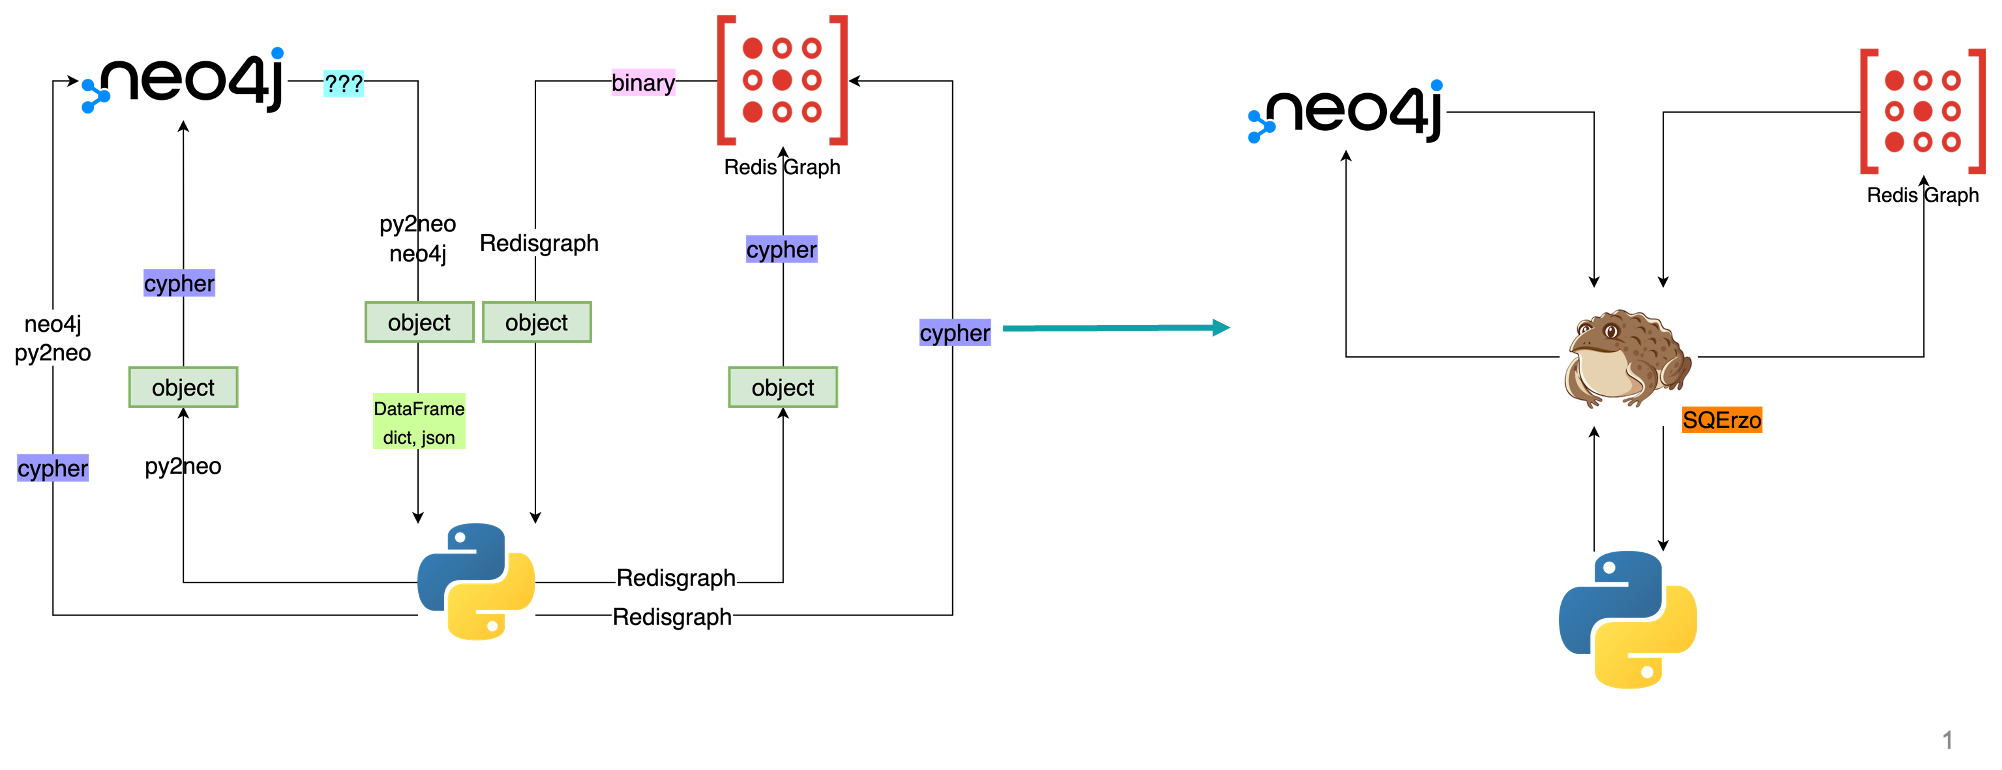